In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def brier_score(pred_prob, ytrue):
  return np.mean((pred_prob - ytrue)**2)

In [4]:
# Read in data and clean it up for testing (i.e. use season averages)
DATA_PATH = 'drive/MyDrive/march_madness/2024/'

df = pd.read_csv(DATA_PATH + 'final_data_2003-2023.csv')

print(df.shape)
df.head()

(4284, 18)


,Season,TeamIDA,TeamIDB,Weights,SeedA,SeedB,WinRatio14A,OffEffA,DefEffA,EFTA,WinRatioA,WinRatio14B,OffEffB,DefEffB,EFTB,WinRatioB,ScoreDiff,WinA
0,2003,1421,1411,2,16,16,1.000000,105.315164,115.456256,0.489800,0.448276,0.833333,107.187241,105.071425,0.503036,0.600000,8,1
1,2003,1112,1436,2,1,16,0.666667,115.232944,95.117513,0.517632,0.892857,1.000000,106.911164,99.247639,0.494732,0.655172,29,1
2,2003,1113,1272,2,10,7,0.500000,113.782349,103.406731,0.517334,0.620690,0.750000,109.889666,97.004974,0.498337,0.793103,13,1
3,2003,1141,1166,2,11,6,1.000000,114.122499,105.421379,0.572835,0.793103,1.000000,118.566346,96.739284,0.567455,0.878788,6,1
4,2003,1143,1301,2,8,9,0.500000,109.611481,102.725168,0.524098,0.724138,0.500000,111.669631,105.001178,0.534189,0.600000,2,1


In [ ]:
# Set up X and Y
to_drop = ['Season', 'TeamIDB', 'ScoreDiff', 'WinA']
X = df.drop(to_drop, axis=1)
Y = df['WinA']

# Split into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Use standard scaler on features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression()
model.fit(X_train_scaled, Y_train)
print('Training accuracy: {:.4f}'.format(model.score(X_train_scaled, Y_train)))
print('Testing accuracy: {:.4f}'.format(model.score(X_test_scaled, Y_test)))

train_prob = model.predict_proba(X_train_scaled)
test_prob = model.predict_proba(X_test_scaled)

print('Training Brier Score: {:.4f}'.format(brier_score(train_prob[:,1], Y_train)))
print('Testing Brier Score: {:.4f}'.format(brier_score(test_prob[:,1], Y_test)))

Training accuracy: 0.7321
Testing accuracy: 0.7419
Training Brier Score: 0.4806
Testing Brier Score: 0.4908


### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

100%|██████████| 99/99 [01:26<00:00,  1.15it/s]


<Axes: xlabel='max_depth'>

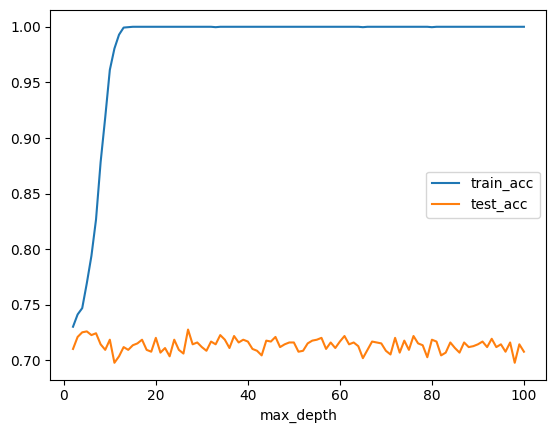

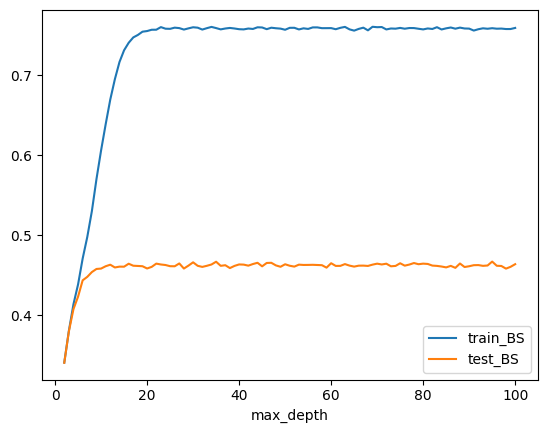

In [ ]:
max_depth_min = 2
max_depth_max = 100

max_depth_list = []
train_acc = []
test_acc = []
train_BS = []
test_BS = []

for m in tqdm(np.arange(max_depth_min, max_depth_max+1)):
  max_depth_list.append(m)
  model = RandomForestClassifier(max_depth=m)
  model.fit(X_train_scaled, Y_train)
  train_acc.append(model.score(X_train_scaled, Y_train))
  test_acc.append(model.score(X_test_scaled, Y_test))

  train_prob = model.predict_proba(X_train_scaled)
  test_prob = model.predict_proba(X_test_scaled)

  train_BS.append(brier_score(train_prob[:,1], Y_train))
  test_BS.append(brier_score(test_prob[:,1], Y_test))


errors = pd.DataFrame()
errors['max_depth'] = max_depth_list
errors['train_acc'] = train_acc
errors['test_acc'] = test_acc
errors['train_BS'] = train_BS
errors['test_BS'] = test_BS

errors.plot(x='max_depth', y=['train_acc', 'test_acc'])
errors.plot(x='max_depth', y=['train_BS', 'test_BS'])

In [ ]:
errors_RF = errors.copy()

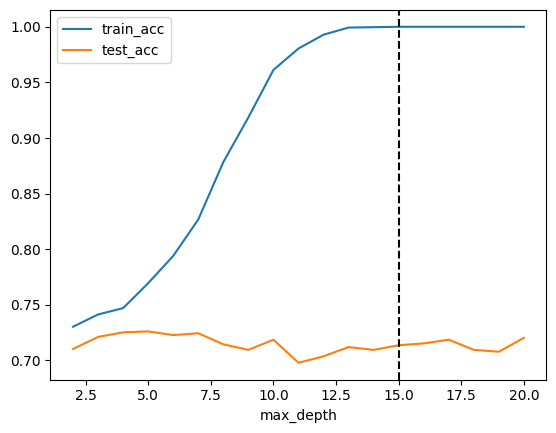

In [ ]:
errors_RF[errors_RF['max_depth'] <= 20].plot(x='max_depth', y=['train_acc', 'test_acc'])
plt.axvline(15, ls='dashed', c='k')

In [ ]:
errors_RF[errors_RF['max_depth'] == 15]

,max_depth,train_acc,test_acc,train_BS,test_BS
13,15,1.0,0.713693,0.730994,0.46073


### Gradient tree boosting

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
params = {
    'n_estimators' : 100,
    'max_depth' : 2,
    'learning_rate' : 0.2,
    'subsample' : 0.5,
    'min_samples_leaf' : 100,
    'max_leaf_nodes' : 1000
    }

gbc = GradientBoostingClassifier(**params, verbose=1)
gbc.fit(X_train_scaled, Y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3055           0.0753            0.73s
         2           1.2497           0.0575            0.72s
         3           1.2112           0.0443            0.68s
         4           1.1717           0.0294            0.65s
         5           1.1660           0.0250            0.64s
         6           1.1208           0.0184            0.63s
         7           1.1026           0.0119            0.62s
         8           1.0787           0.0111            0.61s
         9           1.0793           0.0100            0.60s
        10           1.0836           0.0088            0.59s
        20           1.0276           0.0014            0.51s
        30           1.0423          -0.0021            0.49s
        40           0.9991          -0.0007            0.41s
        50           1.0023          -0.0004            0.34s
        60           0.9571          -0.0022            0.27s
       

GradientBoostingClassifier(learning_rate=0.2, max_depth=2, max_leaf_nodes=1000,
                           min_samples_leaf=100, subsample=0.5, verbose=1)

In [ ]:
print('Training accuracy: {:.4f}'.format(gbc.score(X_train_scaled, Y_train)))
print('Testing accuracy: {:.4f}'.format(gbc.score(X_test_scaled, Y_test)))

train_prob = gbc.predict_proba(X_train_scaled)
test_prob = gbc.predict_proba(X_test_scaled)

print('Training Brier Score: {:.4f}'.format(brier_score(train_prob[:,1], Y_train)))
print('Testing Brier Score: {:.4f}'.format(brier_score(test_prob[:,1], Y_test)))

Training accuracy: 0.7698
Testing accuracy: 0.7145
Training Brier Score: 0.1548
Testing Brier Score: 0.1742


For parameters:

`n_estimators = 1000`, `max_depth = None`, `learning_rate = 0.2`, `subsample = 0.5` \\
> Brier Score = 0.2733

`n_estimators = 1000`, `max_depth = 10`, `learning_rate = 0.2`, `subsample = 0.5` \\
> Brier Score = 0.2674

`n_estimators = 1000`, `max_depth = 2`, `learning_rate = 0.2`, `subsample = 0.5` \\
> Brier Score = 0.2125

`n_estimators = 1000`, `max_depth = 2`, `learning_rate = 0.8`, `subsample = 0.5` \\
> Brier Score = 0.2662

`n_estimators = 1000`, `max_depth = 2`, `learning_rate = 0.5`, `subsample = 0.5` \\
> Brier Score = 0.2378

`n_estimators = 100`, `max_depth = 2`, `learning_rate = 0.2`, `subsample = 0.5` \\
> Brier Score = 0.1745

`n_estimators = 5000`, `max_depth = 2`, `learning_rate = 0.2`, `subsample = 0.5` \\
> Brier Score = 0.2488

`n_estimators = 5000`, `max_depth = 2`, `learning_rate = 0.2`, `subsample = 0.9` \\
> Brier Score = 0.2532

`n_estimators = 100`, `max_depth = 10`, `learning_rate = 0.2`, `subsample = 0.5` \\
> Brier Score = 0.2267

`n_estimators = 100`, `max_depth = 2`, `learning_rate = 0.1`, `subsample = 0.5` \\
> Brier Score = 0.1747

`n_estimators = 100`, `max_depth = 2`, `learning_rate = 0.2`, `subsample = 0.5` \\
`min_samples_leaf = 100` \\
> Brier Score = 0.1742

`n_estimators = 1000`, `max_depth = 2`, `learning_rate = 0.2`, `subsample = 0.5` \\
`min_samples_leaf = 100`, `max_leaf_nodes = 10` \\
> Brier Score = 0.1991

`n_estimators = 1000`, `max_depth = 2`, `learning_rate = 0.2`, `subsample = 0.5` \\
`min_samples_leaf = 1`, `max_leaf_nodes = 10` \\
> Brier Score = 0.2128

`n_estimators = 1000`, `max_depth = 2`, `learning_rate = 0.2`, `subsample = 0.5` \\
`min_samples_leaf = 100`, `max_leaf_nodes = 1000` \\
> Brier Score = 0.1964

Text(0, 0.5, 'counts')

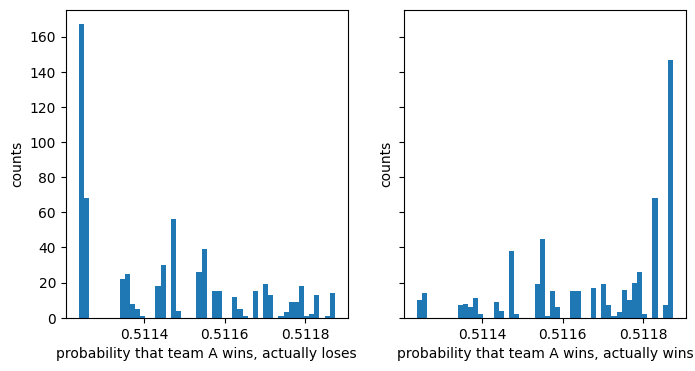

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)

ax[0].hist(test_prob[Y_test == 0,1], bins=50)
ax[0].set_xlabel('probability that team A wins, actually loses')
ax[0].set_ylabel('counts')

ax[1].hist(test_prob[Y_test == 1,1], bins=50)
ax[1].set_xlabel('probability that team A wins, actually wins')
ax[1].set_ylabel('counts')

In [ ]:
parameters = {'max_depth':np.arange(2,20), 'learning_rate':10**np.linspace(-5,1, num=10)}
gbc = GradientBoostingClassifier(n_estimators=100, subsample=0.5, min_samples_leaf=100, verbose=1)
model = GridSearchCV(gbc, parameters, n_jobs=-1, verbose=3, scoring=brier_score)
model.fit(X_train_scaled, Y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


KeyboardInterrupt: 

In [ ]:
print('Training accuracy: {:.4f}'.format(model.best_estimator_.score(X_train_scaled, Y_train)))
print('Testing accuracy: {:.4f}'.format(model.best_estimator_.score(X_test_scaled, Y_test)))

train_prob = model.best_estimator_.predict_proba(X_train_scaled)
test_prob = model.best_estimator_.predict_proba(X_test_scaled)

print('Training Brier Score: {:.4f}'.format(brier_score(train_prob[:,1], Y_train)))
print('Testing Brier Score: {:.4f}'.format(brier_score(test_prob[:,1], Y_test)))

Training accuracy: 0.5116
Testing accuracy: 0.4730
Training Brier Score: 0.2498
Testing Brier Score: 0.2506


Text(0, 0.5, 'counts')

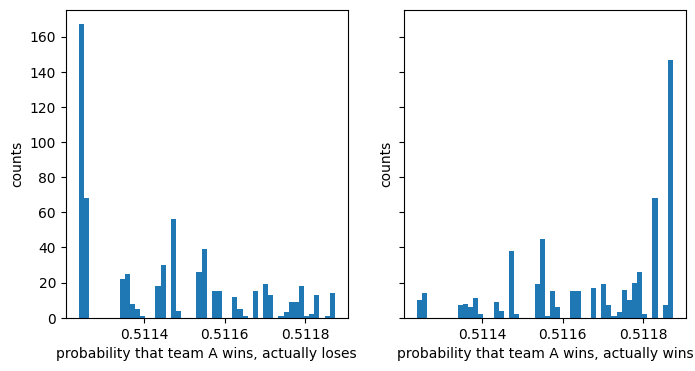

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)

ax[0].hist(test_prob[Y_test == 0,1], bins=50)
ax[0].set_xlabel('probability that team A wins, actually loses')
ax[0].set_ylabel('counts')

ax[1].hist(test_prob[Y_test == 1,1], bins=50)
ax[1].set_xlabel('probability that team A wins, actually wins')
ax[1].set_ylabel('counts')